# H5: Follicle Vascularization vs Size Relationship Depends on Genotype

**Rationale:** Larger follicles may need proportionally more vessels. If SH2B3 loss-of-function alters vascular patterning, the scaling relationship (vessel count vs follicle area) may differ by genotype.

**Technical approach:** Assign each follicle-parented SmallVessel to its nearest follicle annotation using cKDTree on centroids.

> **Caveat:** With n=3–4 per group, these analyses are exploratory. Effect sizes are more informative than p-values.

In [1]:
import sys
sys.path.insert(0, '.')
from data_utils import *
from scipy.stats import linregress
setup_style()

df = load_data()

# Assign vessels to follicles for each image
all_assigned = []
for image in df['Image'].unique():
    assigned = assign_vessels_to_follicles(df, image)
    if not assigned.empty:
        all_assigned.append(assigned)

fol_vessels = pd.concat(all_assigned, ignore_index=True)
print(f"Assigned {len(fol_vessels)} vessels to follicles across {fol_vessels['Image'].nunique()} images")

# Per-follicle aggregation
per_fol = fol_vessels.groupby(['Image', 'Sample', 'Genotype', 'Follicle_ID', 'Follicle_Area'],
                               observed=True).size().reset_index(name='Vessel_Count')
per_fol['Follicle_Area_mm2'] = per_fol['Follicle_Area'] / 1e6
per_fol['Vessel_Density'] = per_fol['Vessel_Count'] / per_fol['Follicle_Area_mm2']

# Add follicles with zero vessels
regions = get_regions(df)
all_follicles = regions[regions['Classification'] == 'Follicle'][['Image', 'Sample', 'Genotype', 'Object ID', 'Area µm^2']].copy()
all_follicles.rename(columns={'Object ID': 'Follicle_ID', 'Area µm^2': 'Follicle_Area'}, inplace=True)
all_follicles['Follicle_Area_mm2'] = all_follicles['Follicle_Area'] / 1e6

# Merge to include zero-vessel follicles
per_fol_full = all_follicles.merge(
    per_fol[['Follicle_ID', 'Vessel_Count', 'Vessel_Density']],
    on='Follicle_ID', how='left'
)
per_fol_full['Vessel_Count'] = per_fol_full['Vessel_Count'].fillna(0).astype(int)
per_fol_full['Vessel_Density'] = per_fol_full['Vessel_Count'] / per_fol_full['Follicle_Area_mm2']

print(f"Total follicles: {len(per_fol_full)} ({(per_fol_full['Vessel_Count'] == 0).sum()} with 0 vessels)")
print(f"Correlation (area vs count): r={np.corrcoef(per_fol_full['Follicle_Area'], per_fol_full['Vessel_Count'])[0,1]:.3f}")

Assigned 22525 vessels to follicles across 10 images
Total follicles: 1879 (348 with 0 vessels)
Correlation (area vs count): r=0.686


## Figure 1: Follicle Area vs Vessel Count (log-log)

Saved: analysis/figures/H5_area_vs_count_loglog.png


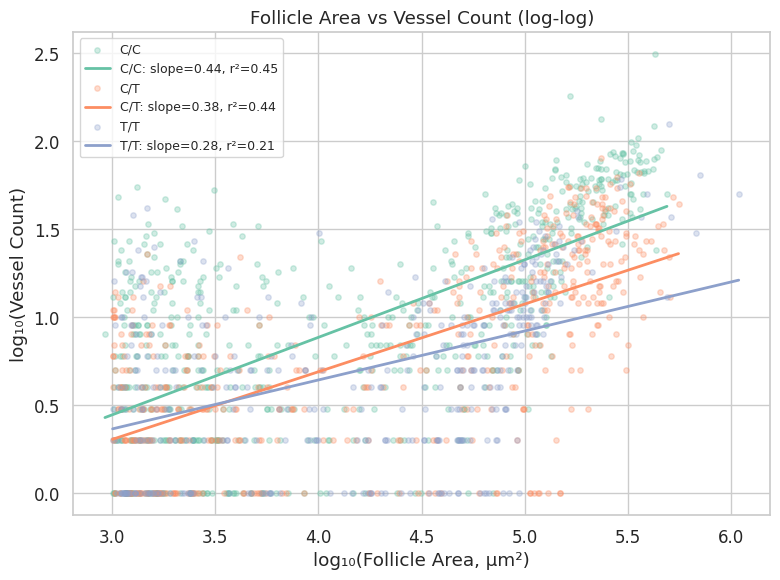

In [2]:
# Filter to follicles with >0 vessels for log-log
plot_fol = per_fol_full[per_fol_full['Vessel_Count'] > 0].copy()
plot_fol['log_area'] = np.log10(plot_fol['Follicle_Area'])
plot_fol['log_count'] = np.log10(plot_fol['Vessel_Count'])

fig, ax = plt.subplots(figsize=(8, 6))

for geno in GENO_ORDER:
    gd = plot_fol[plot_fol['Genotype'] == geno]
    ax.scatter(gd['log_area'], gd['log_count'], color=GENO_PALETTE[geno],
               alpha=0.3, s=15, label=geno)
    # Regression line
    if len(gd) > 2:
        slope, intercept, r, p, se = linregress(gd['log_area'], gd['log_count'])
        x_line = np.linspace(gd['log_area'].min(), gd['log_area'].max(), 50)
        ax.plot(x_line, slope * x_line + intercept, color=GENO_PALETTE[geno],
                linewidth=2, label=f'{geno}: slope={slope:.2f}, r²={r**2:.2f}')

ax.set_xlabel('log₁₀(Follicle Area, µm²)')
ax.set_ylabel('log₁₀(Vessel Count)')
ax.set_title('Follicle Area vs Vessel Count (log-log)')
ax.legend(fontsize=9)

fig.tight_layout()
save_figure(fig, 'H5_area_vs_count_loglog')
plt.show()

## Figure 2: Per-Image Regression Slopes (log-log)

/tmp/ipykernel_262069/3704911198.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=slopes_df, x='Genotype', y='Slope', order=GENO_ORDER,
/tmp/ipykernel_262069/3704911198.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=slopes_df, x='Genotype', y='Slope', order=GENO_ORDER,


Saved: analysis/figures/H5_regression_slopes.png


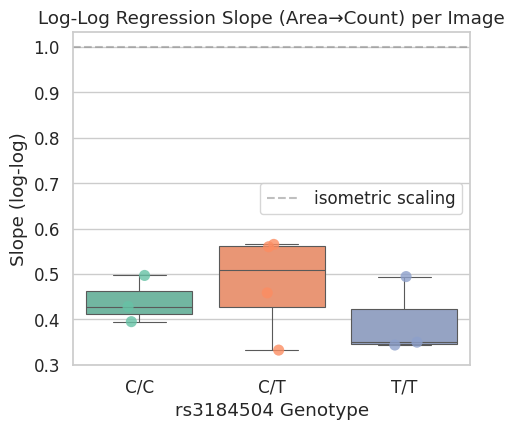

,Image,Sample,Genotype,Slope,R_squared,N_follicles
0,1901HBMP004_PC29.ome.tiff,1901HBMP004,T/T,0.350,0.316,44
1,HDL011_PC33.ome.tiff,HDL011,C/C,0.497,0.528,86
2,HDL043_PC33.ome.tiff,HDL043,C/T,0.332,0.422,141
3,HDL052SPLN_2025Aug6_Scan1.er.qptiff - resoluti...,HDL052,C/T,0.565,0.769,20
4,HDL053_PC33.ome.tif,HDL053,C/C,0.428,0.530,375
5,HDL055_PC33.ome.tiff,HDL055,C/C,0.395,0.505,192
6,HDL063_PC33.ome.tiff,HDL063,T/T,0.494,0.280,206
7,HDL070_SPLN_2025Aug8_Scan1.er.qptiff - resolut...,HDL070,C/T,0.458,0.569,209
8,HDL073_PC29.ome.tiff,HDL073,T/T,0.343,0.257,136
9,HDL086_PC33.ome.tiff,HDL086,C/T,0.560,0.597,122


In [3]:
# Compute per-image slopes
slopes = []
for (image, sample, geno), group in plot_fol.groupby(['Image', 'Sample', 'Genotype'], observed=True):
    if len(group) < 5:
        continue
    slope, intercept, r, p, se = linregress(group['log_area'], group['log_count'])
    slopes.append({'Image': image, 'Sample': sample, 'Genotype': geno,
                   'Slope': slope, 'R_squared': r**2, 'N_follicles': len(group)})

slopes_df = pd.DataFrame(slopes)

fig, ax = plt.subplots(figsize=(5, 4.5))
sns.boxplot(data=slopes_df, x='Genotype', y='Slope', order=GENO_ORDER,
            palette=GENO_PALETTE, ax=ax, linewidth=0.8, fliersize=0)
sns.stripplot(data=slopes_df, x='Genotype', y='Slope', order=GENO_ORDER,
              palette=GENO_PALETTE, ax=ax, size=8, alpha=0.8)
ax.axhline(1, color='gray', linestyle='--', alpha=0.5, label='isometric scaling')
ax.set_title('Log-Log Regression Slope (Area→Count) per Image')
ax.set_ylabel('Slope (log-log)')
ax.set_xlabel('rs3184504 Genotype')
ax.legend()

fig.tight_layout()
save_figure(fig, 'H5_regression_slopes')
plt.show()

display(slopes_df.round(3))

## Figure 3: Per-Follicle Vessel Density

/tmp/ipykernel_262069/2118449046.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=per_fol_full, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
/tmp/ipykernel_262069/2118449046.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=img_density, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
/tmp/ipykernel_262069/2118449046.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=img_density, x='Genotype', y='Vessel_Density', order=GENO_ORDER,


Saved: analysis/figures/H5_follicle_vessel_density.png


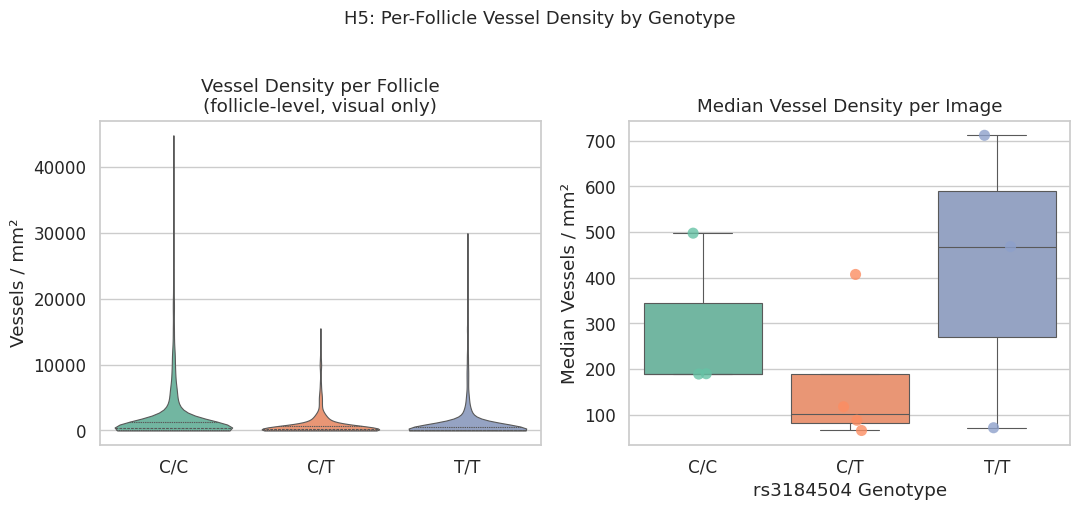

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Left: violin (follicle-level, visual only)
ax = axes[0]
sns.violinplot(data=per_fol_full, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
               palette=GENO_PALETTE, ax=ax, inner='quartile', cut=0, linewidth=0.8)
ax.set_title('Vessel Density per Follicle\n(follicle-level, visual only)')
ax.set_ylabel('Vessels / mm²')
ax.set_xlabel('')

# Right: boxplot of per-image medians
img_density = per_fol_full.groupby(['Image', 'Sample', 'Genotype'], observed=True)['Vessel_Density'].median().reset_index()

ax = axes[1]
sns.boxplot(data=img_density, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
            palette=GENO_PALETTE, ax=ax, linewidth=0.8, fliersize=0)
sns.stripplot(data=img_density, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
              palette=GENO_PALETTE, ax=ax, size=8, alpha=0.8)
ax.set_title('Median Vessel Density per Image')
ax.set_ylabel('Median Vessels / mm²')
ax.set_xlabel('rs3184504 Genotype')

fig.suptitle('H5: Per-Follicle Vessel Density by Genotype', fontsize=13, y=1.02)
fig.tight_layout()
save_figure(fig, 'H5_follicle_vessel_density')
plt.show()

## Figure 4: Vessel Density by Follicle Size Tertile

/tmp/ipykernel_262069/2827867950.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=td, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
/tmp/ipykernel_262069/2827867950.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=td, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
/tmp/ipykernel_262069/2827867950.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=td, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
/tmp/ipykernel_262069/2827867950.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is de

Saved: analysis/figures/H5_density_by_size_tertile.png


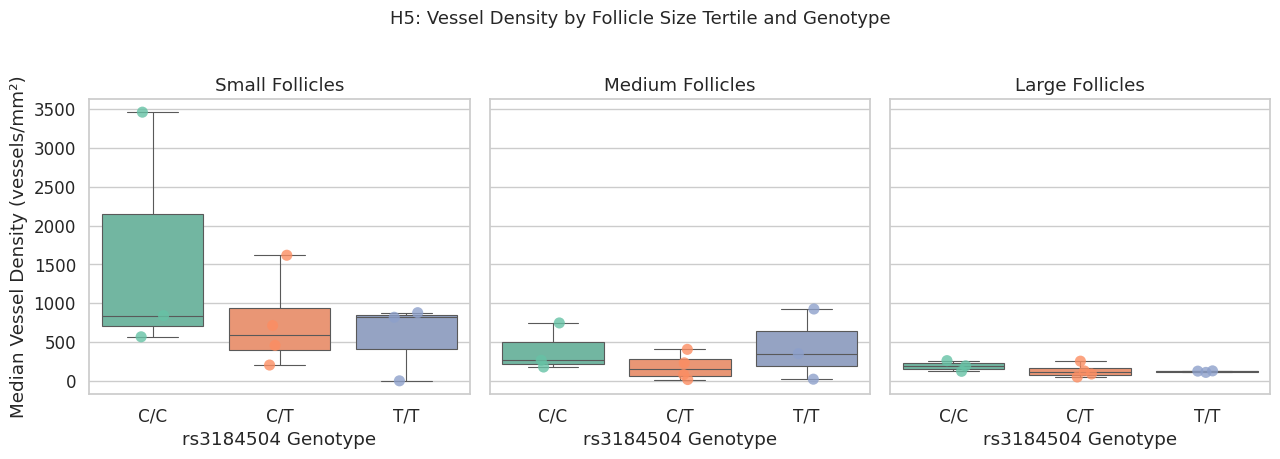

In [5]:
# Size tertiles across all follicles
tertile_labels = ['Small', 'Medium', 'Large']
per_fol_full['Size_Tertile'] = pd.qcut(per_fol_full['Follicle_Area'], q=3, labels=tertile_labels)

# Per-image median within each tertile
tert_img = per_fol_full.groupby(['Image', 'Sample', 'Genotype', 'Size_Tertile'],
                                 observed=True)['Vessel_Density'].median().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), sharey=True)

for ax, tert in zip(axes, tertile_labels):
    td = tert_img[tert_img['Size_Tertile'] == tert]
    sns.boxplot(data=td, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
                palette=GENO_PALETTE, ax=ax, linewidth=0.8, fliersize=0)
    sns.stripplot(data=td, x='Genotype', y='Vessel_Density', order=GENO_ORDER,
                  palette=GENO_PALETTE, ax=ax, size=8, alpha=0.8)
    ax.set_title(f'{tert} Follicles')
    ax.set_xlabel('rs3184504 Genotype')
    if ax == axes[0]:
        ax.set_ylabel('Median Vessel Density (vessels/mm²)')
    else:
        ax.set_ylabel('')

fig.suptitle('H5: Vessel Density by Follicle Size Tertile and Genotype', fontsize=13, y=1.02)
fig.tight_layout()
save_figure(fig, 'H5_density_by_size_tertile')
plt.show()

## Summary Tables

In [6]:
# Per-follicle summary statistics
pf_summary = per_fol_full.groupby('Genotype', observed=True).agg(
    N_follicles=('Follicle_ID', 'count'),
    Mean_Vessel_Count=('Vessel_Count', 'mean'),
    Median_Vessel_Count=('Vessel_Count', 'median'),
    Mean_Vessel_Density=('Vessel_Density', 'mean'),
    Median_Vessel_Density=('Vessel_Density', 'median'),
    Mean_Follicle_Area=('Follicle_Area', 'mean'),
).round(2).reset_index()

save_table(pf_summary, 'H5_per_follicle_summary')
display(pf_summary)

Saved: analysis/tables/H5_per_follicle_summary.csv


,Genotype,N_follicles,Mean_Vessel_Count,Median_Vessel_Count,Mean_Vessel_Density,Median_Vessel_Density,Mean_Follicle_Area
0,C/C,754,17.18,7.0,1829.24,334.72,60379.04
1,C/T,596,10.16,4.0,882.04,181.75,73101.00
2,T/T,529,6.65,3.0,981.72,118.95,43802.37


In [7]:
# Regression slopes table
save_table(slopes_df.round(4), 'H5_regression_slopes')
display(slopes_df.round(4))

Saved: analysis/tables/H5_regression_slopes.csv


,Image,Sample,Genotype,Slope,R_squared,N_follicles
0,1901HBMP004_PC29.ome.tiff,1901HBMP004,T/T,0.3495,0.3163,44
1,HDL011_PC33.ome.tiff,HDL011,C/C,0.4966,0.5280,86
2,HDL043_PC33.ome.tiff,HDL043,C/T,0.3320,0.4219,141
3,HDL052SPLN_2025Aug6_Scan1.er.qptiff - resoluti...,HDL052,C/T,0.5651,0.7688,20
4,HDL053_PC33.ome.tif,HDL053,C/C,0.4279,0.5295,375
5,HDL055_PC33.ome.tiff,HDL055,C/C,0.3947,0.5051,192
6,HDL063_PC33.ome.tiff,HDL063,T/T,0.4941,0.2798,206
7,HDL070_SPLN_2025Aug8_Scan1.er.qptiff - resolut...,HDL070,C/T,0.4582,0.5689,209
8,HDL073_PC29.ome.tiff,HDL073,T/T,0.3433,0.2569,136
9,HDL086_PC33.ome.tiff,HDL086,C/T,0.5599,0.5973,122


In [8]:
# Statistical tests
all_stats = []

# Per-image median vessel density
all_stats.append(full_stats_table(img_density, 'Vessel_Density', label='Per-image median vessel density'))

# Regression slopes
all_stats.append(full_stats_table(slopes_df, 'Slope', label='Log-log regression slope'))

# Per-tertile density
for tert in tertile_labels:
    td = tert_img[tert_img['Size_Tertile'] == tert]
    all_stats.append(full_stats_table(td, 'Vessel_Density', label=f'Vessel density ({tert} follicles)'))

stats_df = pd.concat(all_stats, ignore_index=True)
save_table(stats_df, 'H5_statistical_tests')
display(stats_df)

Saved: analysis/tables/H5_statistical_tests.csv


,Test,Metric,Statistic,p,Effect_Size
0,Kruskal-Wallis,Per-image median vessel density,2.227273,0.328363,
1,Mann-Whitney (C/C vs C/T),Per-image median vessel density,10.000000,0.228571,r=-0.667
2,Mann-Whitney (C/C vs T/T),Per-image median vessel density,4.000000,1.000000,r=0.111
3,Mann-Whitney (C/T vs T/T),Per-image median vessel density,3.000000,0.400000,r=0.500
4,Spearman dosage,Per-image median vessel density,0.000000,1.000000,rho=0.000
5,Kruskal-Wallis,Log-log regression slope,1.181818,0.553824,
6,Mann-Whitney (C/C vs C/T),Log-log regression slope,4.000000,0.628571,r=0.333
7,Mann-Whitney (C/C vs T/T),Log-log regression slope,7.000000,0.400000,r=-0.556
8,Mann-Whitney (C/T vs T/T),Log-log regression slope,8.000000,0.628571,r=-0.333
9,Spearman dosage,Log-log regression slope,-0.224733,0.532481,rho=-0.225
